# Table of Contents

1. [**Dependencies**](#Dependencies)
2. [**Clustered Ti Orientations**](#Clustered-Ti-Orientations)
3. [**Clustered Ti misorientations**](#Clustered-Ti-misorientations)

In [1]:
%matplotlib inline

# Important external dependencies
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN

# Other external dependencies
from sklearn.datasets import make_blobs
from tqdm import tqdm_notebook

# Local dependencies
from texpy.quaternion.orientation import Orientation, Misorientation
from texpy.quaternion.rotation import Rotation
from texpy.quaternion.symmetry import C1, D6h, D6, Oh
from texpy.quaternion.orientation_region import OrientationRegion
from texpy.vector.neo_euler import AxAngle
from texpy.vector import Vector3d
from texpy import plot

# Colorisation
from skimage.color import label2rgb
from matplotlib.colors import to_rgb, to_hex
MPL_COLORS_RGB = [to_rgb('C{}'.format(i)) for i in range(10)]
MPL_COLORS_HEX = [to_hex(c) for c in MPL_COLORS_RGB]

# Animation
import matplotlib.animation as animation

# Visualisation
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from matplotlib.patches import Circle
from matplotlib.lines import Line2D
from matplotlib.collections import CircleCollection
from scipy.spatial import ConvexHull
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

plt.rc('font', size=6)

# Clustered Ti Orientations

In [2]:
# Load data from CTF file
dat = np.loadtxt('./data/Ti_orientations.ctf', skiprows=1)[:, :3]

In [3]:
ori = Orientation.from_euler(np.radians(dat)).reshape(381, 507)[-100:, :200]
fundamental_region = OrientationRegion.from_symmetry(D6)

print('Number of orientations:', ori.size)

Number of orientations: 20000


## Calculate disorientations

**Option 1: quick, will wreck your RAM**

Computes every possibility in a single tensor, then minimises.

In [ ]:
# Compute misorientations
confirm = input('Are you sure? (y/n) ')
if confirm == 'y':
    misori_equiv = D6.outer(~ori).outer(ori).outer(D6)
    D = misori_equiv.angle.data.min(axis=(0, 2))

**Option 2: medium-speed, should be OK for RAM**

Precomputes one set of equivalent orientations.

In [ ]:
D = np.zeros(ori.shape + ori.shape)
D.fill(np.infty)

OS2 = ori.outer(D6)

for i in tqdm_notebook(range(ori.size)):
    idx = np.unravel_index(i, ori.shape)
    o_1 = ori[idx]
    misori = D6.outer(~o_1).outer(OS2)
    d = misori.angle.data.min(axis=(0, -1))
    D[idx[0], idx[1], ...] = np.minimum(D[idx[0], idx[1], ...], d)

**Option 3: slow, safe for RAM**

Iterates through every pair of orientations.

In [ ]:
from itertools import combinations_with_replacement as icombinations
D = np.empty(ori.shape + ori.shape)

for i, j in tqdm_notebook(list(icombinations(range(ori.size), 2))):
    idx_1, idx_2 = np.unravel_index(i, ori.shape), np.unravel_index(i, ori.shape)
    o_1, o_2 = ori[idx_1], ori[idx_2]
    misori = D6.outer(~o_1).outer(o_2).outer(D6)
    d = misori.angle.data.min(axis=(0, 3))
    D[idx_1[0], idx_1[1], idx_2[0], idx_2[1]] = d
    D[idx_2[0], idx_2[1], idx_1[0], idx_1[1]] = d

**Here's one I made earlier**

In [4]:
D = np.load('./data/ori-distance((100, 200)).npy')

## Clustering

In [5]:
# Get main clusters
dbscan = DBSCAN(0.05, 40, metric='precomputed').fit(D.reshape(ori.size, ori.size))
print('Labels:', np.unique(dbscan.labels_))
labels = dbscan.labels_.reshape(ori.shape)
n_clusters = len(np.unique(dbscan.labels_)) - 1
print('Number of clusters:', n_clusters)

Labels: [-1  0  1  2  3  4  5  6]
Number of clusters: 7


In [6]:
cluster_means = Orientation.stack([ori[labels == label].mean() for label in np.unique(dbscan.labels_)[1:]]).flatten()
cluster_means = cluster_means.set_symmetry(D6)

In [7]:
cluster_means.axis

Vector3d (7,)
[[ 0.2291 -0.9481 -0.2203]
 [ 0.7324  0.639  -0.2351]
 [ 0.8599 -0.3759  0.3454]
 [ 0.7944  0.5061 -0.3358]
 [ 0.4276  0.9026  0.0502]
 [ 0.9284  0.2895  0.2331]
 [-0.5937 -0.7922  0.1411]]

In [8]:
# Recenter based on the matrix cluster and recompute means
ori_recentered = (~cluster_means[0]) * ori
ori_recentered = ori_recentered.set_symmetry(D6)
cluster_means_recentered = Orientation.stack([ori_recentered[labels == label].mean() for label in np.unique(dbscan.labels_)[1:]]).flatten()
cluster_means_axangle = AxAngle.from_rotation(cluster_means_recentered)

In [9]:
cluster_means_recentered.axis

Vector3d (7,)
[[ 0.0204 -0.0077 -0.9998]
 [-0.4984 -0.867  -0.0003]
 [ 0.5009  0.8655 -0.0014]
 [-0.4949 -0.8689  0.0094]
 [-0.4874 -0.873   0.0196]
 [-0.8532 -0.5215  0.0066]
 [-0.9598 -0.1242 -0.2516]]

## Plotting

In [ ]:
%matplotlib qt5
fig = plt.figure(figsize=(3.484252, 6.5))
ax_ori = fig.add_subplot(gridspec[0], projection='axangle', proj_type='ortho')
ax_ori.plot_wireframe(fundamental_region, color='black', linewidth=0.5, alpha=0.1, rcount=181, ccount=361)

In [ ]:
# get label colors
colors = [to_rgb('C{}'.format(i)) for i in range(10)]
labels_rgb = label2rgb(labels, colors=colors)

# Create map and lines pointing to cluster means
mapping = labels_rgb
collection = Line3DCollection([((0, 0, 0), tuple(cm)) for cm in cluster_means_axangle.data], colors=colors)

In [ ]:
# Main plot
fig = plt.figure(figsize=(3.484252, 3.484252))
gridspec = plt.GridSpec(1, 1, left=0, right=1, bottom=0, top=1, hspace=0.05)

ax_ori = fig.add_subplot(gridspec[0], projection='axangle', proj_type='ortho')
ax_ori.scatter(ori_recentered, c=labels_rgb.reshape(-1, 3), s=1)
ax_ori.plot_wireframe(fundamental_region, color='black', linewidth=0.5, alpha=0.1, rcount=181, ccount=361)
ax_ori.add_collection3d(collection)

ax_ori.set_axis_off()
ax_ori.set_xlim(-1, 1)
ax_ori.set_ylim(-1, 1)
ax_ori.set_zlim(-1, 1)
ax_ori.view_init(90, -30)

# Legend
handles = [
    Line2D(
        [0], [0], 
        marker='o', color='none', 
        label=i+1, 
        markerfacecolor=color, markersize=5
    ) for i, color in enumerate(colors[:n_clusters])
]

ax_ori.legend(handles=handles, loc='lower right', ncol=2, numpoints=1, labelspacing=0.15, columnspacing=0.15, handletextpad=0.05)
fig.savefig('./clustered-orientations-top-data.png', transparent=True, dpi=600)

In [ ]:
fig = plt.figure(figsize=(3.484252 * 2, 1.5 * 2))
gridspec = plt.GridSpec(1, 1, left=0, right=1, bottom=0, top=1, hspace=0.05)

ax_ori = fig.add_subplot(gridspec[0], projection='axangle', proj_type='ortho', aspect='equal')
ax_ori.scatter(ori_recentered, c=labels_rgb.reshape(-1, 3), s=1)
ax_ori.plot_wireframe(fundamental_region, color='black', linewidth=0.5, alpha=0.1, rcount=181, ccount=361)
# ax_ori.add_collection3d(collection)

ax_ori.set_axis_off()
ax_ori.set_xlim(-1, 1)
ax_ori.set_ylim(-1, 1)
ax_ori.set_zlim(-1, 1)
ax_ori.view_init(0, -30)
fig.savefig('./clustered-orientations-side-data.png', transparent=True, dpi=900)

In [ ]:
ax_mapping = fig.add_subplot(gridspec[2])
ax_mapping.imshow(mapping)

ax_mapping.set_xticks([])
ax_mapping.set_yticks([])

fig.savefig('./clustered-orientations-data.png', transparent=True, dpi=600)

# Clustered Ti misorientations

In [11]:
# Load data from CTF file
dat = np.loadtxt('./data/Ti_orientations.ctf', skiprows=1)[:, :3]

ori = Orientation.from_euler(np.radians(dat)).reshape(381, 507)[-100:, :200].set_symmetry(D6)

fundamental_region = OrientationRegion.from_symmetry(D6, D6)

# Compute misorientations
misori_base = Misorientation(~ori[:, :-1] * ori[:, 1:])
boundary_mask = misori_base.angle > np.radians(7)
misori = misori_base[boundary_mask].set_symmetry(D6, D6)
print('Number of misorientations:', misori.size)

Number of misorientations: 860


In [12]:
small_mask = misori.angle < np.radians(7)

## Compute D-matrix

**The RAM-wrecking option**

In [ ]:
mismisori = (~misori).outer(misori)
mismisori_equiv = D6.outer(~misori).outer(D6).outer(D6).outer(misori).outer(D6)
distance = mismisori_equiv.angle.data.min(axis=(0, 2, 3, 5))

**The slow-but-sane option** (about 20 mins)

In [ ]:
from itertools import combinations_with_replacement as icombinations
from tqdm import tqdm_notebook
distance = np.empty((misori.size, misori.size))

for i, j in tqdm_notebook(list(icombinations(range(misori.size), 2))):
    m_1, m_2 = misori[i], misori[j]
    mismisori = D6.outer(~m_1).outer(D6).outer(D6).outer(m_2).outer(D6)
    d = mismisori.angle.data.min(axis=(0, 2, 3, 5))
    distance[i, j] = d
    distance[j, i] = d

In [ ]:
np.save('./misori-distance((300, 500)).npy', distance)

**The priori incantatem option**

In [13]:
distance = np.load('./data/misori-distance((100, 200)).npy')

## Clusters

In [14]:
distance = distance[~small_mask][:, ~small_mask]

In [15]:
# Compute clusters
dbscan = DBSCAN(0.05, 10, metric='precomputed').fit(distance)
print('Cluster labels:', np.unique(dbscan.labels_))
n_clusters = len(np.unique(dbscan.labels_)) - 1
print('Number of clusters:', n_clusters)

# Generate colors
colors = [to_rgb('C{}'.format(i)) for i in range(10)]  # ['C0', 'C1', ...]
c = label2rgb(dbscan.labels_, colors=colors)

Cluster labels: [-1  0  1  2  3]
Number of clusters: 4


In [16]:
misori = misori[~small_mask]

In [17]:
cluster_means = Misorientation.stack([misori[dbscan.labels_ == label].mean() for label in np.unique(dbscan.labels_)[1:]]).flatten()
cluster_means = cluster_means.set_symmetry(D6, D6)

In [18]:
cluster_means

Misorientation (4,) 622, 622
[[0.8775 0.4194 0.2328 0.0039]
 [0.825  0.4794 0.2991 0.0047]
 [0.9622 0.242  0.1244 0.0071]
 [0.8656 0.4338 0.2501 0.0055]]

In [19]:
np.degrees(cluster_means.angle.data)

array([57.32484832, 68.81388421, 31.58939741, 60.10115054])

In [23]:
clusters_labelled = [misori[dbscan.labels_ == label] for label in np.unique(dbscan.labels_)[1:]]

In [51]:
np.argmin(distance[dbscan.labels_ == 0][:, dbscan.labels_ == 0].sum(axis=1))

184

In [55]:
median_0 = clusters_labelled[0][184]
np.degrees(median_0.angle.data)

array([64.29410714])

In [52]:
np.argmin(distance[dbscan.labels_ == 1][:, dbscan.labels_ == 1].sum(axis=1))

84

In [56]:
median_1 = clusters_labelled[1][84]
np.degrees(median_1.angle.data)

array([77.0003489])

In [42]:
np.argmin(distance[dbscan.labels_ == 2][:, dbscan.labels_ == 2].sum(axis=0))

74

In [57]:
median_2 = clusters_labelled[2][74]
np.degrees(median_2.angle.data)

array([34.69263698])

In [44]:
np.argmin(distance[dbscan.labels_ == 3][:, dbscan.labels_ == 3].sum(axis=0))

51

In [58]:
median_3 = clusters_labelled[3][51]
np.degrees(median_3.angle.data)

array([60.17984152])

In [ ]:
# Generate map
mapping = np.ones(misori_base.shape + (3,))

mapping[np.where(boundary_mask)[0][~small_mask], np.where(boundary_mask)[1][~small_mask]] = c

## Plot

/home/hremadmin/anaconda3/lib/python3.6/site-packages/texpy/quaternion/orientation_region.py:166: RuntimeWarning: divide by zero encountered in reciprocal
  x = 2 * np.arctan(x**-1)
/home/hremadmin/anaconda3/lib/python3.6/site-packages/texpy/quaternion/orientation_region.py:166: RuntimeWarning: invalid value encountered in arctan
  x = 2 * np.arctan(x**-1)


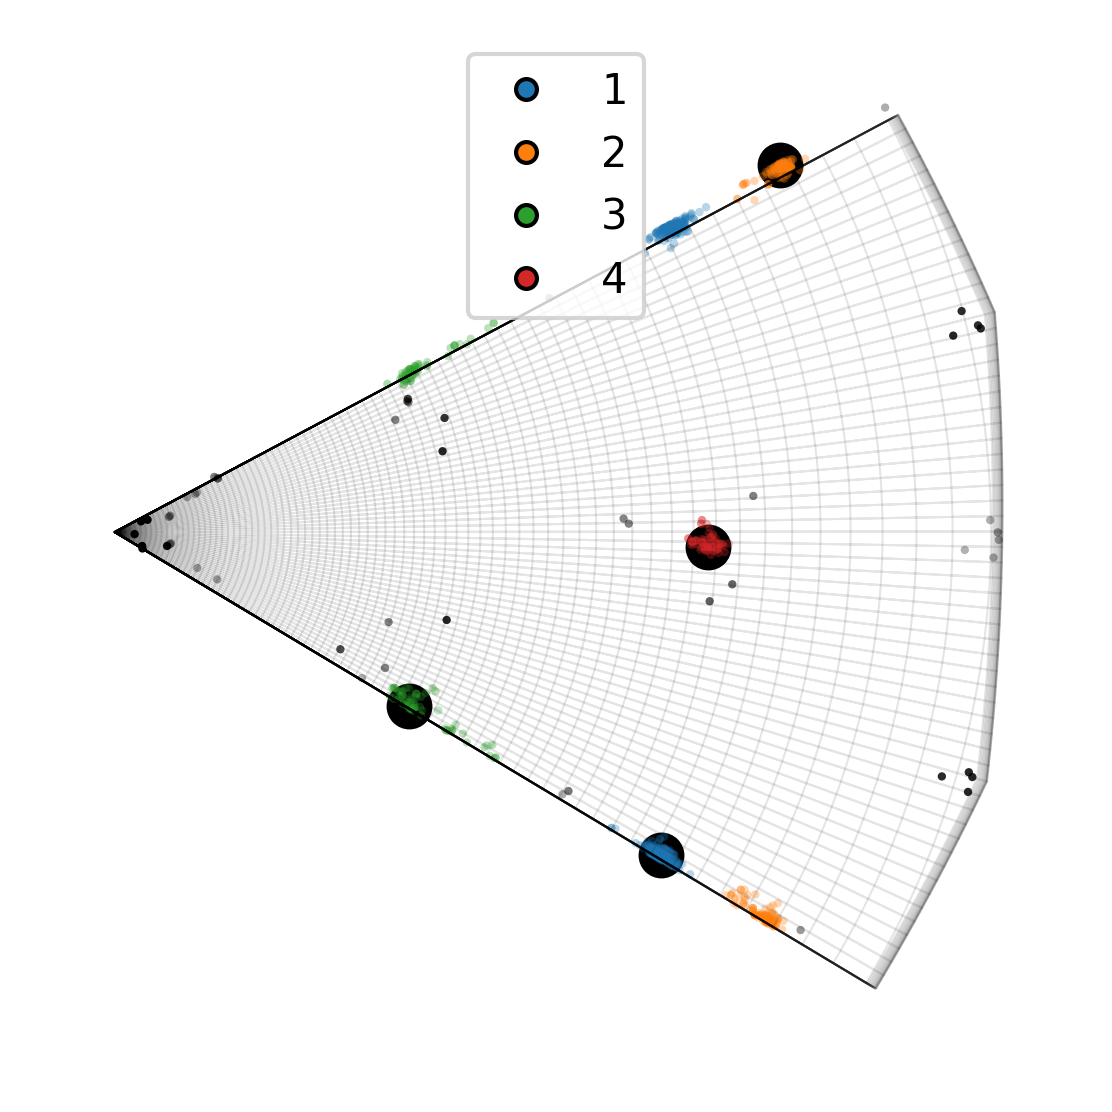

In [60]:
# Plot clustered misorientations
fig = plt.figure(figsize=(3.484252, 3.484252), dpi=300)
gridspec = plt.GridSpec(1, 1, left=0, right=1, bottom=0, top=1, hspace=0.05)


ax_misori = fig.add_subplot(gridspec[0], projection='axangle', aspect='equal', proj_type='ortho')
ax_misori.scatter(misori, c=c, s=4, edgecolor='none')
ax_misori.scatter(median_0, c='k', s=100)
ax_misori.scatter(median_1, c='k', s=100)
ax_misori.scatter(median_2, c='k', s=100)
ax_misori.scatter(median_3, c='k', s=100)


ax_misori.plot_wireframe(fundamental_region, color='black', linewidth=0.5, alpha=0.1, rcount=361, ccount=361)

ax_misori.set_axis_off()
ax_misori.set_xlim(0.2, 1.2)
ax_misori.set_ylim(-.1, .9)
ax_misori.set_zlim(-0, 1)
ax_misori.view_init(90, -60)


handles = [
    Line2D(
        [0], [0], 
        marker='o', color='none', 
        label=i+1, 
        markerfacecolor=color, markersize=5
    ) for i, color in enumerate(colors[:n_clusters])
]

ax_misori.legend(handles=handles, loc='upper center')

# fig.savefig('./clustered-misorientations-top-data.png', transparent=True, dpi=600)

In [ ]:
fig = plt.figure(figsize=(3.484252*2, 1.5*2))
gridspec = plt.GridSpec(1, 1, left=0, right=1, bottom=0, top=1, hspace=0.05)

ax_misori = fig.add_subplot(gridspec[0], projection='axangle', proj_type='ortho', aspect='equal')
ax_misori.scatter(misori, c=c, s=4, edgecolor='none')
ax_misori.plot_wireframe(fundamental_region, color='black', linewidth=0.5, alpha=0.1, rcount=181, ccount=361)

ax_misori.set_axis_off()
ax_misori.set_xlim(0.1, 1.1)
ax_misori.set_ylim(0.1, 1.1)
ax_misori.set_zlim(-0, 1)
ax_misori.view_init(0, -60)


fig.savefig('./clustered-misorientations-side-data.png', transparent=True, dpi=600)

In [ ]:
fig = plt.figure(figsize=(3.484252, 2))

gridspec = plt.GridSpec(1, 1, left=0, right=1, bottom=0, top=1, hspace=0.05)
ax_mapping = fig.add_subplot(gridspec[0])
ax_mapping.imshow(mapping)

ax_mapping.set_xticks([])
ax_mapping.set_yticks([])

fig.savefig('./clustered-misorientations-mapping-data.png', transparent=True, dpi=600)